In [13]:
# !ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [14]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- [ ] 데이터의 중복 제거
- [ ] NaN 결측치 제거
- [ ] 한국어 토크나이저로 토큰화
- [ ] 불용어(Stopwords) 제거
- [ ] 사전word_to_index 구성
- [ ] 텍스트 스트링을 사전 인덱스 스트링으로 변환
- [ ] X_train, y_train, X_test, y_test, word_to_index 리턴

In [48]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
vocab_size=10000

def count_diff(func):
    def wrapper(df):
        before = len(df)
        result = func(df)
        after = len(df)
        
        print(f'{func.__name__}: {after - before}')
        return result
    return wrapper



def load_data(train_data, test_data, num_words=vocab_size):
    @count_diff
    def drop_dup(df):
        return df.drop_duplicates(subset=['document'])

    @count_diff
    def drop_na(df):
        return df.dropna(how = 'any')

      
    train_data = drop_na(drop_dup(train_data))
    test_data = drop_na(drop_dup(test_data))
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [
            word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] 
            for word in wordlist
        ]
    
    # TODO: 만약 UNK가 많이 있으면 어떻게 함?
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

drop_dup: 0
drop_na: 0
drop_dup: 0
drop_na: 0


In [49]:
tokens = 0
cnt = 0
for row in X_train + X_test:
    tokens += len(row)
    cnt += row.count(word_to_index['<UNK>'])
print(f'{tokens}중에서 {cnt}가 UNK이기 때문에 나중에 처리해줘야한다.')

3119447중에서 137148가 UNK이기 때문에 나중에 처리해줘야한다.


In [50]:
index_to_word = {index:word for word, index in word_to_index.items()}

print(list(word_to_index.keys())[:4])
print(list(index_to_word.values())[:4])

['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']
['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']


In [51]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index=word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index=word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word=index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word=index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [52]:
for i in range(5):
    print(f'--[{i+1}]번째----')    
    print(f"원본: {train_data['document'][i]}")
    print(f'전처리후: {get_decoded_sentence(X_train[i])}')

--[1]번째----
원본: 아 더빙.. 진짜 짜증나네요 목소리
전처리후: 더 빙 . . 진짜 짜증 나 네요 목소리
--[2]번째----
원본: 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
전처리후: . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
--[3]번째----
원본: 너무재밓었다그래서보는것을추천한다
전처리후: 재 <UNK>
--[4]번째----
원본: 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
전처리후: 이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
--[5]번째----
원본: 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
전처리후: 익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다


In [53]:
!pip install rich

     |████████████████████████████████| 240 kB 5.2 MB/s            
     |████████████████████████████████| 87 kB 10.6 MB/s            
     |████████████████████████████████| 1.2 MB 64.8 MB/s            
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.10.0
    Uninstalling Pygments-2.10.0:
      Successfully uninstalled Pygments-2.10.0


In [54]:
import builtins
import rich

builtins.print = rich.print

## 적절한 문장길이
1. 평균길이+2X표준편차
2. IQR

15.96940191154864

116

12.843571191092

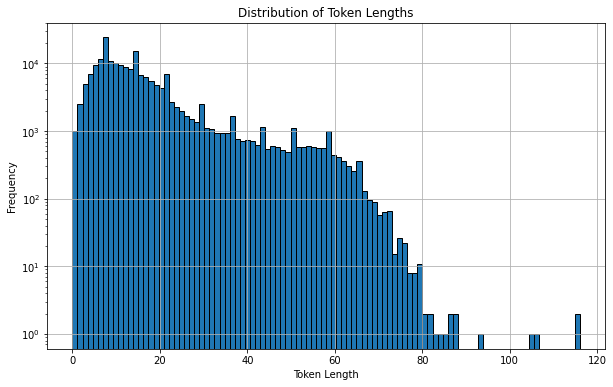

In [60]:
import matplotlib.pyplot as plt

num_tokens = np.array([len(s) for s in list(X_train) + list(X_test)])
print(np.mean(num_tokens))
print(np.max(num_tokens))
print(np.std(num_tokens))


plt.figure(figsize=(10, 6))
plt.hist(num_tokens, bins=100, edgecolor='black')
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.grid(True)
plt.show()

# TODO: 이상치 제거

In [61]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41

전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.

## prepadding

- Q. RNN 활용 시 pad_sequences의 padding 방식은 'post'와 'pre' 중 어느 것이 유리할까요?

> 누군가의 설명: RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됩니다.

> 내 생각: tanh가 중첩되면 vanishing이 일어난다. vanishing은 앞쪽이 더 영향을 받으니, 앞쪽에 의미없는 padding을 둔다. 위의 설명은 말이 안되는게 무의미한 padding인건 앞이든 뒤든 똑같은데 뭘 주장하는지 모르겠다.


`pad_sequences(value=)` value는 padding value를 의미한다.

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# TODO: test
# 💡: padding은 앞쪽이 맞는 것 같고, trunc은 뒤쪽 없애는게 더 자연스러울 것 같다.

padding = 'pre' # pre, post
truncating = 'post' # pre, post


X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding=padding,
                                                        truncating=truncating,
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding=padding,
                                                       truncating=truncating,
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)

(49157, 41)

## 4) 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=34)

In [100]:
from keras.callbacks import EarlyStopping

vocab_size = 10000 # vocab_size 사실 위에 init
word_vector_dim = 300  # 워드 벡터의 차원 수 
callbacks = [
    EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
]

def LSTM(embeddings):
    
    model = keras.Sequential(
        [
            embeddings,
            keras.layers.LSTM(512),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    print(model.summary())
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


model = LSTM(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model.evaluate(x_test,  y_test, verbose=2)

"""
1537/1537 - 5s - loss: 0.6865 - accuracy: 0.8439
[0.6865183711051941, 0.8438879251480103]
"""
print(results)

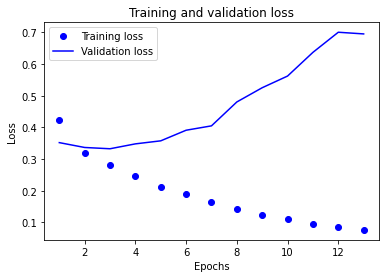

In [73]:
def plot_history(history):
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.clf()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [99]:
def CONV_1D(embeddings):
    model = keras.Sequential(
        [
            embeddings,
            tf.keras.layers.Conv1D(16, 7, activation='relu'),
            tf.keras.layers.MaxPooling1D(5),
            tf.keras.layers.Conv1D(16, 7, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    print(model.summary())
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = CONV_1D(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    verbose=1)

"""
1537/1537 - 3s - loss: 0.9672 - accuracy: 0.8263
[0.9672241806983948, 0.8262912631034851]
"""
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)
plot_history(history)

In [98]:
def ONLY_MAX_POOLING(embeddings):
    model = keras.Sequential(
        [
            embeddings,
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ]
    )
    print(model.summary())
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = ONLY_MAX_POOLING(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    verbose=1)

"""
1537/1537 - 2s - loss: 0.6796 - accuracy: 0.8398
[0.6795628070831299, 0.8398193717002869]
"""
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)
plot_history(history)

## Word2Vec 
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 

```py
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
```

In [85]:
!ls /aiffel/data

GoogleNews-vectors-negative300.bin.gz  word2vec_ko.model
ratings_test.txt                       word2vec_ko.model.trainables.syn1neg.npy
ratings_train.txt                      word2vec_ko.model.wv.vectors.npy

In [ ]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
print(word2vec.wv['클레멘타인'])

In [91]:
print(word2vec.wv.similar_by_word('클레멘타인'))

[('애나벨', 0.7087948322296143),
 ('헤이즐', 0.7083200812339783),
 ('워록', 0.7045043706893921),
 ('브로더릭', 0.6918909549713135),
 ('클룸', 0.6898564100265503),
 ('질런홀', 0.6832016706466675),
 ('Gwen', 0.6791983842849731),
 ('앳웰', 0.6785181164741516),
 ('스카페이스', 0.6774739623069763),
 ('버드맨', 0.6749832630157471)]

In [102]:
word2vec.wv['클레멘타인'].shape

(100,)

In [107]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

# stateful so
def get_w2v_embedding(vocab_size, word_vector_dim, embedding_matrix, maxlen):
    return tf.keras.layers.Embedding(
        vocab_size, 
        word_vector_dim, 
        embeddings_initializer=Constant(embedding_matrix),
        input_length=maxlen, 
        trainable=True
    )

In [115]:
def do_experiment(
    embeddings, 
    batch_size, 
    callbacks=callbacks, 
    X_train=X_train, 
    y_train=y_train, 
    validation_data=(X_val, y_val)
):
    models = (
        ('LSTM', LSTM(embeddings)),
        ('CONV', CONV_1D(embeddings)),
        ('POOL', ONLY_MAX_POOLING(embeddings)),
    )

    results = {}
    for key, model in models:    
        history = model.fit(X_train,
                            y_train,
                            epochs=20,
                            batch_size=batch_size,
                            callbacks=callbacks,
                            validation_data=validation_data,
                            verbose=0)
        results[key] = {
            'history': history,
            'result': model.evaluate(x_test,  y_test, verbose=2)
        }
    return results


batch_size = 512
embeddings = get_w2v_embedding(vocab_size, word_vector_dim, embedding_matrix, maxlen)
results = do_experiment(embeddings, batch_size)

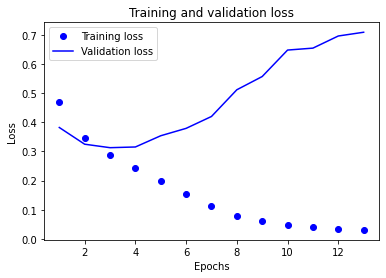

[0.7266714572906494, 0.8490550518035889]

In [110]:
plot_history(results['LSTM']['history'])
print(results['LSTM']['result'])

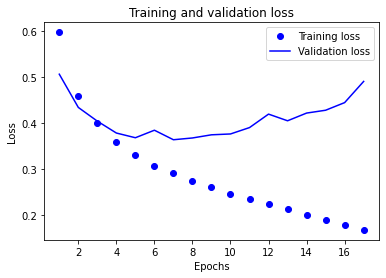

[0.5007306337356567, 0.8278170228004456]

In [111]:
plot_history(results['CONV']['history'])
print(results['CONV']['result'])

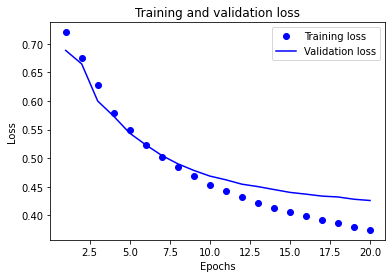

[0.4293563663959503, 0.8038325905799866]

In [112]:
plot_history(results['POOL']['history'])
print(results['POOL']['result'])

> batch 사이즈 512일때는 3가지 모델 모두, 85%를 넘지 못하고 있다.

이를 해결하기 위해서, batch_size를 줄여보자

In [117]:
batch_size = 256
embeddings = get_w2v_embedding(vocab_size, word_vector_dim, embedding_matrix, maxlen)
results = do_experiment(embeddings, batch_size)

Model: "sequential_13"

_________________________________________________________________

Layer (type)                 Output Shape              Param #

=================================================================

embedding_16 (Embedding)     (None, 41, 100)           1000000

_________________________________________________________________

lstm_5 (LSTM)                (None, 512)               1255424

_________________________________________________________________

dense_26 (Dense)             (None, 8)                 4104

_________________________________________________________________

dense_27 (Dense)             (None, 1)                 9

=================================================================

Total params: 2,259,537

Trainable params: 2,259,537

Non-trainable params: 0

_________________________________________________________________

None

Model: "sequential_14"

_________________________________________________________________

Layer (type)                 Output Shape              Param #

=================================================================

embedding_16 (Embedding)     (None, 41, 100)           1000000

_________________________________________________________________

conv1d_8 (Conv1D)            (None, 35, 16)            11216

_________________________________________________________________

max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0

_________________________________________________________________

conv1d_9 (Conv1D)            (None, 1, 16)             1808

_________________________________________________________________

global_max_pooling1d_8 (Glob (None, 16)                0

_________________________________________________________________

dense_28 (Dense)             (None, 8)                 136

_________________________________________________________________

dense_29 (Dense)             (None, 1)                 9

=================================================================

Total params: 1,013,169

Trainable params: 1,013,169

Non-trainable params: 0

_________________________________________________________________

None

Model: "sequential_15"

_________________________________________________________________

Layer (type)                 Output Shape              Param #

=================================================================

embedding_16 (Embedding)     (None, 41, 100)           1000000

_________________________________________________________________

global_max_pooling1d_9 (Glob (None, 100)               0

_________________________________________________________________

dense_30 (Dense)             (None, 8)                 808

_________________________________________________________________

dense_31 (Dense)             (None, 1)                 9

=================================================================

Total params: 1,000,817

Trainable params: 1,000,817

Non-trainable params: 0

_________________________________________________________________

None

Epoch 00013: early stopping

1537/1537 - 5s - loss: 0.7648 - accuracy: 0.8565


Epoch 00014: early stopping

1537/1537 - 3s - loss: 0.4931 - accuracy: 0.8369
1537/1537 - 2s - loss: 0.4114 - accuracy: 0.8201


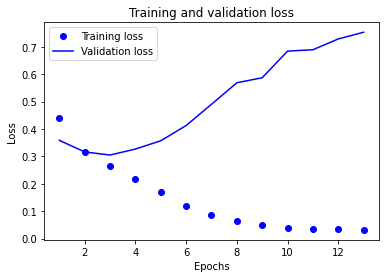

[0.7648211121559143, 0.85652095079422]

In [118]:
plot_history(results['LSTM']['history'])
print(results['LSTM']['result'])

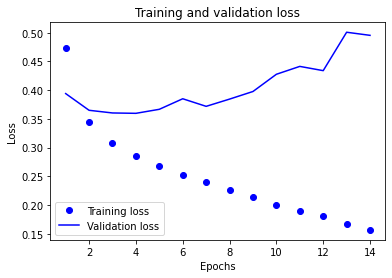

[0.49311184883117676, 0.8368899822235107]

In [119]:
plot_history(results['CONV']['history'])
print(results['CONV']['result'])

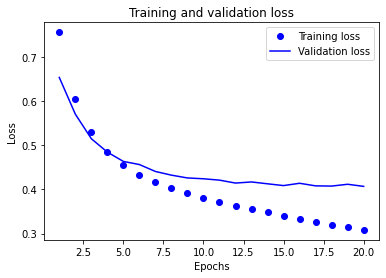

[0.41136085987091064, 0.8200663328170776]

In [120]:
plot_history(results['POOL']['history'])
print(results['POOL']['result'])

## 회고

LSTM + Word2vec 모델은 85% 이상의 성능을 확보하였다.


In [123]:
def LSTM_NORM(embeddings):
    model = keras.Sequential(
        [
            embeddings,
            keras.layers.LSTM(512),
            keras.layers.LayerNormalization(),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    print(model.summary())
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

batch_size = 256
model = LSTM_NORM(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential_18"

_________________________________________________________________

Layer (type)                 Output Shape              Param #

=================================================================

embedding_19 (Embedding)     (None, None, 100)         1000000

_________________________________________________________________

lstm_8 (LSTM)                (None, 512)               1255424

_________________________________________________________________

layer_normalization (LayerNo (None, 512)               1024

_________________________________________________________________

dense_36 (Dense)             (None, 8)                 4104

_________________________________________________________________

dense_37 (Dense)             (None, 1)                 9

=================================================================

Total params: 2,260,561

Trainable params: 2,260,561

Non-trainable params: 0

_________________________________________________________________

None

Epoch 1/20

457/457 [==============================] - 17s 34ms/step - loss: 0.4584 - accuracy: 0.7977 - val_loss: 0.3560 - val_accuracy: 0.8438


Epoch 2/20

457/457 [==============================] - 16s 35ms/step - loss: 0.3171 - accuracy: 0.8624 - val_loss: 0.3345 - val_accuracy: 0.8540


Epoch 3/20

457/457 [==============================] - 16s 34ms/step - loss: 0.2679 - accuracy: 0.8855 - val_loss: 0.3444 - val_accuracy: 0.8569


Epoch 4/20

457/457 [==============================] - 15s 33ms/step - loss: 0.2312 - accuracy: 0.9033 - val_loss: 0.3630 - val_accuracy: 0.8505


Epoch 5/20

457/457 [==============================] - 15s 33ms/step - loss: 0.2004 - accuracy: 0.9174 - val_loss: 0.3669 - val_accuracy: 0.8510


Epoch 6/20

457/457 [==============================] - 15s 33ms/step - loss: 0.1727 - accuracy: 0.9296 - val_loss: 0.4197 - val_accuracy: 0.8506


Epoch 7/20

457/457 [==============================] - 15s 33ms/step - loss: 0.1490 - accuracy: 0.9401 - val_loss: 0.4512 - val_accuracy: 0.8503


Epoch 8/20

457/457 [==============================] - 15s 34ms/step - loss: 0.1302 - accuracy: 0.9484 - val_loss: 0.5052 - val_accuracy: 0.8472


Epoch 9/20

457/457 [==============================] - 15s 34ms/step - loss: 0.1152 - accuracy: 0.9539 - val_loss: 0.5333 - val_accuracy: 0.8480


Epoch 10/20

457/457 [==============================] - 15s 33ms/step - loss: 0.0993 - accuracy: 0.9607 - val_loss: 0.6077 - val_accuracy: 0.8464


Epoch 11/20

457/457 [==============================] - 15s 33ms/step - loss: 0.0882 - accuracy: 0.9646 - val_loss: 0.6638 - val_accuracy: 0.8433


Epoch 12/20

457/457 [==============================] - 15s 33ms/step - loss: 0.0793 - accuracy: 0.9681 - val_loss: 0.6839 - val_accuracy: 0.8425


Epoch 00012: early stopping

1537/1537 - 5s - loss: 0.6898 - accuracy: 0.8376


> Normalization layers usually apply their normalization effect to the previous layer, so it should be put in front of the layer that you want normalized.

normalization을 했는데 더 성능이 좋아지진 않았다.

In [128]:
embedding_layer = model.layers[0]
embedding_matrix = embedding_layer.get_weights()[0]

from gensim.models import KeyedVectors

word_vectors = KeyedVectors(vector_size=word_vector_dim)
for i in range(4,vocab_size):
    word_vectors.add_vectors(index_to_word[i], embedding_matrix[i])

# Fine tunning된 워드 임베딩
word_vectors.similar_by_word(word_to_index['타이타닉'])

[('1992', 0.8096157312393188),
 ('테', 0.7751392126083374),
 ('일어났', 0.7378237843513489),
 ('콜린스', 0.7122530341148376),
 ('착하', 0.7100092172622681),
 ('까먹', 0.707072377204895),
 ('국민', 0.7033789157867432),
 ('바지', 0.7028982043266296),
 ('이따', 0.6908925771713257),
 ('채민서', 0.6907433867454529)]

In [129]:
# 최초의 워드 임베딩
word2vec.wv.similar_by_word('타이타닉')

[('브리타닉', 0.7651368975639343),
 ('노틸러스', 0.7062833905220032),
 ('바운티', 0.6730524897575378),
 ('보리알리스', 0.6610607504844666),
 ('인데버', 0.6517763137817383),
 ('보이저', 0.6426752209663391),
 ('아라온', 0.6318589448928833),
 ('이타스카', 0.6298863291740417),
 ('챔플레인', 0.6284394264221191),
 ('비글', 0.6260406374931335)]

In [130]:
print(word_vectors.similar_by_word(word_to_index['터미네이터']))
print(word2vec.wv.similar_by_word('터미네이터'))

[
    ('이상실', 0.7095305919647217),
    ('홍콩식', 0.7051594853401184),
    ('저급', 0.6968289017677307),
    ('진행', 0.6951013207435608),
    ('족', 0.6926105618476868),
    ('욕할', 0.6897998452186584),
    ('충동', 0.687019944190979),
    ('애기', 0.6834035515785217),
    ('놀', 0.6824995279312134),
    ('오류', 0.6749060153961182)
]

[
    ('에일리언', 0.8037504553794861),
    ('아이언맨', 0.8001936078071594),
    ('트랜스포머', 0.7760803699493408),
    ('스타워즈', 0.7746523022651672),
    ('스파이더맨', 0.771183967590332),
    ('엑스맨', 0.7410327196121216),
    ('록맨', 0.7400428056716919),
    ('소울칼리버', 0.7331603169441223),
    ('심즈', 0.7300594449043274),
    ('디아블로', 0.7297697067260742)
]

- 1992를 잡아낸것을 보면 그래도 영화 리뷰로 fine tunning한 임베딩이 좀 더 효과적인 것 같다. 
- 하지만 터미네이터의 경우를 보면 영화 리뷰에 초점을 맞춰서 그런지 연관성 없어 보이는 단어들이 들어있긴 한 것 같다.

평가문항
1. [x] 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	(3가지 이상의 모델이 성공적으로 시도됨)
2. [x] gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. [x] 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.	네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## 회고
#### 배운 점
pre, post padding에 대해서 배웠고, vec sim을 해볼 수 있는 실질적인 도구를 익혔다.

#### 아쉬운 점
- dropout, layernorm을 해보고 싶은데 많이 해보지 못했다.
- bpe로 테스트해보고 싶었는데 못했다.

#### 느낀 점
코드가 길어지면 길을 잃기 마련이다. 계속 습관처럼 정리하면서 코드를 만져야겠다.

#### 어려웠던 점
- layer norm을 어디에 넣어야 할지 어려웠다.
- lstm의 unit갯수가 의미하는 바가 조금 헷갈렸다.